In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import torch
%matplotlib inline



In [2]:
import time
import numpy as np
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch
from torch.utils.data import Dataset
import os

In [3]:
from helper_evaluation import set_all_seeds, set_deterministic, compute_confusion_matrix
from helper_train import train_model
from helper_plotting import plot_training_loss, plot_accuracy, show_examples, plot_confusion_matrix

In [4]:
RANDOM_SEED = 123
BATCH_SIZE = 64
NUM_EPOCHS = 30
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
LR = 0.2
NUM_ATTRIBUTE = 12
NUM_HIDDEN_1 = 1024
NUM_HIDDEN_2 = 1024
NUM_HIDDEN_3 = 1024
NUM_HIDDEN_4 = 512
NUM_CLASS = 6
OUTCOME = 'genre'

In [5]:
set_all_seeds(RANDOM_SEED)
set_deterministic()

# Load Data

In [6]:
class MyDataset(Dataset):

    def __init__(self, csv_path):
    
        df = pd.read_csv(csv_path)
        
        self.x = torch.tensor(df.iloc[:, :NUM_ATTRIBUTE].values).float()
        self.y = torch.tensor(df[OUTCOME].values).long()
        
        mean = torch.mean(self.x, dim=0)
        std = torch.std(self.x, dim=0)
        self.x = (self.x - mean)/std
        #print(len(self.x))
        #print(len(self.y))

    def __getitem__(self, index):
        attributes = self.x[index]
        label = self.y[index]
        return attributes, label

    def __len__(self):
        return self.y.shape[0]

In [7]:

train_dataset = MyDataset(csv_path='class_data/spotify_train.csv')

train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          drop_last=True,
                          shuffle=True, # want to shuffle the dataset
                          num_workers=0) # number processes/CPUs to use

valid_dataset = MyDataset(csv_path='class_data/spotify_valid.csv')

valid_loader = DataLoader(dataset=valid_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=False,
                          num_workers=0)



test_dataset = MyDataset(csv_path='class_data/spotify_test.csv')

test_loader = DataLoader(dataset=test_dataset,
                         batch_size=BATCH_SIZE,
                         shuffle=False,
                         num_workers=0)

In [8]:
for attributes, labels in train_loader:  
    print('Image batch dimensions:', attributes.shape)
    print('Image label dimensions:', labels.shape)
    break

Image batch dimensions: torch.Size([64, 12])
Image label dimensions: torch.Size([64])


# ONE-HOT CODE

In [9]:
def to_onehot(y, num_classes):
    y_onehot = torch.FloatTensor(y.size(0), num_classes)
    y_onehot.zero_()
    tmp = y.view(-1, 1).long().to(torch.device('cpu'))
    y_onehot.scatter_(1, tmp, 1).float()
    return y_onehot

# Model

In [10]:
class MLP(torch.nn.Module):

    def __init__(self, num_features, num_hidden_1, num_hidden_2, num_hidden_3, drop_proba, num_classes):
        super().__init__()
        
        self.num_classes = num_classes
        
        self.my_network = torch.nn.Sequential(
            ### 1st hidden layer
            torch.nn.Flatten(),
            torch.nn.Linear(num_features, num_hidden_1, bias=False),
            torch.nn.ReLU(),
            torch.nn.BatchNorm1d(num_hidden_1),
            torch.nn.Dropout(drop_proba),
            ### 2nd hidden layer
            torch.nn.Linear(num_hidden_1, num_hidden_2, bias=False),
            torch.nn.ReLU(),
            torch.nn.BatchNorm1d(num_hidden_2),
            torch.nn.Dropout(drop_proba),
            ### 3rd hidden layer
            torch.nn.Linear(num_hidden_2, num_hidden_3, bias=False),
            torch.nn.ReLU(),
            torch.nn.BatchNorm1d(num_hidden_3),
            torch.nn.Dropout(drop_proba),
            ### Output layer
            torch.nn.Linear(num_hidden_3, num_classes)
        )
        
    def forward(self, x):
        logits = self.my_network(x)
        return logits

## Model Initialization with BatchNorm

Epoch: 001/030 | Batch 0000/0410 | Loss: 1.9948
Epoch: 001/030 | Batch 0050/0410 | Loss: 5.7819
Epoch: 001/030 | Batch 0100/0410 | Loss: 3.2213
Epoch: 001/030 | Batch 0150/0410 | Loss: 3.3092
Epoch: 001/030 | Batch 0200/0410 | Loss: 3.0966
Epoch: 001/030 | Batch 0250/0410 | Loss: 2.6520
Epoch: 001/030 | Batch 0300/0410 | Loss: 4.1969
Epoch: 001/030 | Batch 0350/0410 | Loss: 2.9152
Epoch: 001/030 | Batch 0400/0410 | Loss: 1.7750
Epoch: 001/030 | Train: 44.21% | Validation: 44.58%
Time elapsed: 0.13 min
Epoch: 002/030 | Batch 0000/0410 | Loss: 2.8203
Epoch: 002/030 | Batch 0050/0410 | Loss: 1.8949
Epoch: 002/030 | Batch 0100/0410 | Loss: 1.9812
Epoch: 002/030 | Batch 0150/0410 | Loss: 1.1435
Epoch: 002/030 | Batch 0200/0410 | Loss: 1.6722
Epoch: 002/030 | Batch 0250/0410 | Loss: 3.0216
Epoch: 002/030 | Batch 0300/0410 | Loss: 2.6058
Epoch: 002/030 | Batch 0350/0410 | Loss: 2.0839
Epoch: 002/030 | Batch 0400/0410 | Loss: 1.6325
Epoch: 002/030 | Train: 49.50% | Validation: 47.50%
Time elap

Epoch: 017/030 | Batch 0100/0410 | Loss: 1.2305
Epoch: 017/030 | Batch 0150/0410 | Loss: 1.4168
Epoch: 017/030 | Batch 0200/0410 | Loss: 1.1180
Epoch: 017/030 | Batch 0250/0410 | Loss: 1.1023
Epoch: 017/030 | Batch 0300/0410 | Loss: 1.1386
Epoch: 017/030 | Batch 0350/0410 | Loss: 1.3714
Epoch: 017/030 | Batch 0400/0410 | Loss: 1.1741
Epoch: 017/030 | Train: 55.49% | Validation: 53.29%
Time elapsed: 1.76 min
Epoch: 018/030 | Batch 0000/0410 | Loss: 1.2012
Epoch: 018/030 | Batch 0050/0410 | Loss: 1.2168
Epoch: 018/030 | Batch 0100/0410 | Loss: 1.2400
Epoch: 018/030 | Batch 0150/0410 | Loss: 1.3944
Epoch: 018/030 | Batch 0200/0410 | Loss: 1.1641
Epoch: 018/030 | Batch 0250/0410 | Loss: 1.2329
Epoch: 018/030 | Batch 0300/0410 | Loss: 1.2493
Epoch: 018/030 | Batch 0350/0410 | Loss: 1.0752
Epoch: 018/030 | Batch 0400/0410 | Loss: 1.2925
Epoch: 018/030 | Train: 55.31% | Validation: 53.35%
Time elapsed: 1.85 min
Epoch: 019/030 | Batch 0000/0410 | Loss: 1.3633
Epoch: 019/030 | Batch 0050/0410 |

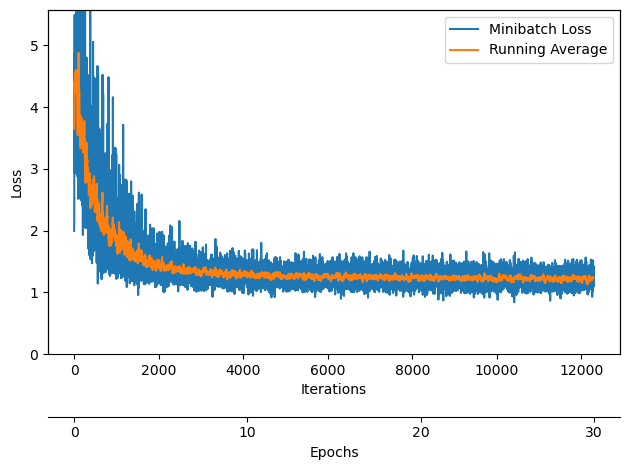

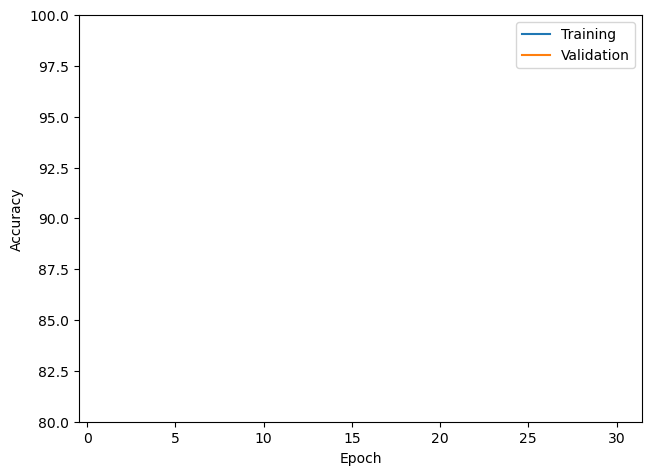

In [11]:
torch.manual_seed(RANDOM_SEED)
model = MLP(num_features=NUM_ATTRIBUTE,
                             num_hidden_1=NUM_HIDDEN_1,
                             num_hidden_2=NUM_HIDDEN_2,
                             num_hidden_3=NUM_HIDDEN_3,
                             drop_proba=0.5,
                             num_classes=NUM_CLASS)
model = model.to(DEVICE)

optimizer = torch.optim.SGD(model.parameters(), lr=LR)

minibatch_loss_list, train_acc_list, valid_acc_list = train_model(
    model=model,
    num_epochs=NUM_EPOCHS,
    train_loader=train_loader,
    valid_loader=valid_loader,
    test_loader=test_loader,
    optimizer=optimizer,
    device=DEVICE)

plot_training_loss(minibatch_loss_list=minibatch_loss_list,
                   num_epochs=NUM_EPOCHS,
                   iter_per_epoch=len(train_loader),
                   results_dir=None,
                   averaging_iterations=20)
plt.show()

plot_accuracy(train_acc_list=train_acc_list,
              valid_acc_list=valid_acc_list,
              results_dir=None)
plt.ylim([80, 100])
plt.show()

In [12]:
def compute_accuracy(net, data_loader):
    correct_pred, num_examples = 0, 0
    with torch.no_grad():
        for features, targets in data_loader:
            features = features.view(-1, NUM_ATTRIBUTE).to(DEVICE)
            targets = targets.to(DEVICE)
            logits = net.forward(features)
            predicted_labels = torch.argmax(logits, 1)
            num_examples += targets.size(0)
            correct_pred += (predicted_labels == targets).sum()
        return correct_pred.float()/num_examples * 100
    
print('Training Accuracy: %.2f' % compute_accuracy(model, train_loader))
print('Test Accuracy: %.2f' % compute_accuracy(model, test_loader))

Training Accuracy: 56.56
Test Accuracy: 54.18


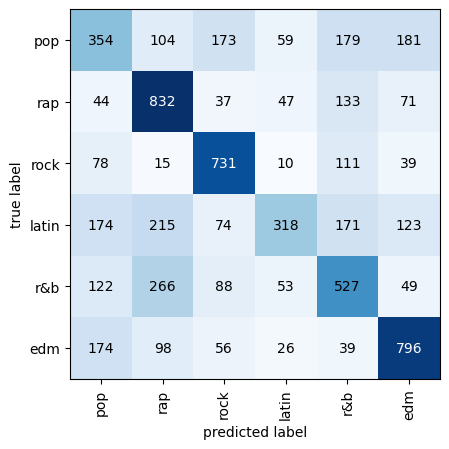

In [13]:
class_dict = {0: 'pop',
              1: 'rap',
              2: 'rock',
              3: 'latin',
              4: 'r&b',
              5: 'edm'}

mat = compute_confusion_matrix(model=model, data_loader=test_loader, device=torch.device('cpu'))
plot_confusion_matrix(mat, class_names=class_dict.values())
plt.show()